<a href="https://colab.research.google.com/github/Varun-3000/Sentiment-Analysis-Using-Reddit-API/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install praw textblob pyspark

In [4]:
import praw
import pandas as pd
from textblob import TextBlob
from datetime import datetime
import os
from pyspark.sql import SparkSession
# Make sure the directory exists
os.makedirs("/dbfs/FileStore/reddit", exist_ok=True)


In [5]:
# Reddit API Auth
reddit = praw.Reddit(
    client_id="your-client-id",
    client_secret="your-client-secret",
    user_agent="Sentiment Analysis Bot by /u/<your-username>"
)

In [6]:
# Fetch latest comments
comments = reddit.subreddit("Python").comments(limit=10)

In [7]:
# Analyze
data = []
for comment in comments:
    polarity = TextBlob(comment.body).sentiment.polarity
    sentiment = "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"
    data.append({
        "timestamp": datetime.utcfromtimestamp(comment.created_utc),
        "author": comment.author.name if comment.author else "N/A",
        "comment": comment.body,
        "sentiment": sentiment
    })


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [8]:
spark = SparkSession.builder \
    .appName("RedditSentiment") \
    .getOrCreate()
# Convert to Spark DF
df = spark.createDataFrame(pd.DataFrame(data))

# Save as Parquet (for efficient storage)
df.write.mode("overwrite").parquet("/dbfs/FileStore/reddit/reddit_sentiment.parquet")

# Convert to CSV for GitHub
df.toPandas().to_csv("/dbfs/FileStore/reddit/reddit_sentiment.csv", index=False)

In [9]:
df_pd = pd.read_csv("/dbfs/FileStore/reddit/reddit_sentiment.csv")
print(df_pd.head())


             timestamp          author  \
0  2025-05-07 13:15:34   Here0s0Johnny   
1  2025-05-07 13:14:15       tangos974   
2  2025-05-07 13:11:27         Cynyr36   
3  2025-05-07 13:10:44  Kooky_Work8978   
4  2025-05-07 13:09:54        bmoregeo   

                                             comment sentiment  
0                              No, it's researech. 😜   neutral  
1  What.\n\nMy dude, I hope this research is for ...  positive  
2  And if it's not numeric, a pandas.series or a ...   neutral  
3  So this "research" assumes that subjects reall...  positive  
4                             clearly for you, typos  positive  


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
import matplotlib.pyplot as plt
sentiment_counts = df_pd['sentiment'].value_counts()



In [12]:
sentiment_counts

,count
sentiment,
positive,5
neutral,4
negative,1


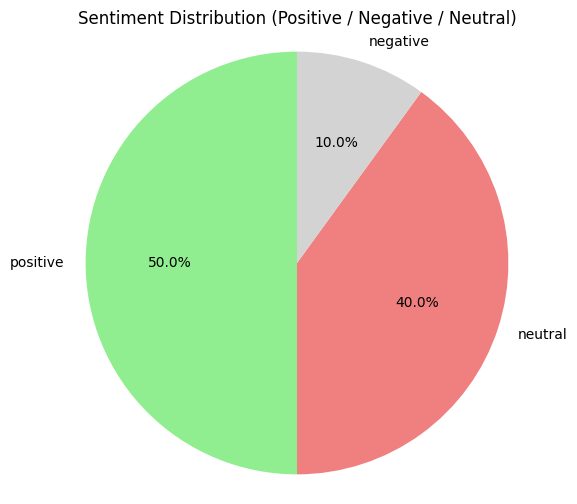

In [13]:
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'lightcoral', 'lightgrey']  # Positive, Negative, Neutral
)
plt.title("Sentiment Distribution (Positive / Negative / Neutral)")
plt.axis('equal')  # Ensures a perfect circle
plt.show()